In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [3]:
def normalized_euclidean_distance_between_tensors(t1, t2):
    vec1 = t1.view(-1)
    vec2 = t2.view(-1)
    vec2[vec2<0.01] = 0
    diff_vec = torch.abs(vec2 - vec1)
    diff_vec[diff_vec>0.05] = 1
    return torch.sum(diff_vec)/vec1.shape[0]

In [4]:
# TODO
# 1. Train VAE on 4 and 9
# 2. Find the sample mean of the TRAINING set of 4 and 5
# 3. Calculate the sample covariance matrix for the (normalize to 0, then xTx, and average it)
# 4. Generate samples of 1000 4s, and 300 4-and-9s

In [2]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    print(in_.shape) if in_ is not None else 0
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            print(in_pic.shape)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(1):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N]) # This line of code is a problem if the last batch has less than 4 images
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(1):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')
        # for i in range(4):
        #     baseline = in_pic[i+4*N] 
        #     current = out_pic[i+4*N]
        #     print(F"Diff score: {normalized_euclidean_distance_between_tensors(baseline, current)}")

In [483]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [6]:
# Define data loading step

# batch_size = 256
# BATCH_SIZE = 8
BATCH_SIZE = 8

class_map = {"null": 4, "positive": 9}
labels_map = {4:0, 9:1} 

def get_loader_for_relevant_targets(dataset, batch_size, class_to_load=None, num_samples=None):
    if class_to_load is None:
        samples_index = torch.logical_or(dataset.targets == class_map["null"] ,dataset.targets == class_map["positive"]).nonzero().reshape(-1)
    else:
        samples_index = (dataset.targets == class_map[class_to_load]).nonzero().reshape(-1)
    if num_samples is not None:
        samples_index = samples_index[:num_samples]
    print(F"sample index: {samples_index.shape}")
    return DataLoader(dataset,batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(samples_index), drop_last=True)

kwargs = {'num_workers': 1, 'pin_memory': True}

In [7]:
train_loader = get_loader_for_relevant_targets(MNIST('./data', train=True, download=True, transform=transforms.ToTensor()),BATCH_SIZE, class_to_load=None)
test_loader = get_loader_for_relevant_targets(MNIST('./data', train=False, transform=transforms.ToTensor()), BATCH_SIZE, class_to_load=None)
test_positive_only = get_loader_for_relevant_targets(MNIST('./data', train=True, transform=transforms.ToTensor()), BATCH_SIZE, class_to_load="positive")
test_null_only = get_loader_for_relevant_targets(MNIST('./data', train=False, transform=transforms.ToTensor()), BATCH_SIZE, class_to_load="null")

sample index: torch.Size([11791])
sample index: torch.Size([1991])
sample index: torch.Size([5949])
sample index: torch.Size([982])


In [8]:
train_null_only = get_loader_for_relevant_targets(MNIST('./data', train=True, download=True, transform=transforms.ToTensor()),BATCH_SIZE, class_to_load="null")
train_positive_only = get_loader_for_relevant_targets(MNIST('./data', train=True, download=True, transform=transforms.ToTensor()),BATCH_SIZE, class_to_load="positive")

sample index: torch.Size([5842])
sample index: torch.Size([5949])


In [ ]:
display_images

In [662]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [514]:
from torch import Tensor
from torch.nn import functional as F

# Defining a dropout layer to also be used for testing
class MCDropout(torch.nn.Dropout):
    def forward(self, input: Tensor) -> Tensor:
        return F.dropout(input, self.p, True, self.inplace)

In [366]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [663]:
# Defining the model

d = 5

class VAES(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            # MCDropout(0.30),
            nn.Linear(400, 400),
            nn.ReLU(),
            # MCDropout(0.30),
            nn.Linear(400, d*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, 400),
            nn.ReLU(),
            # MCDropout(0.30),
            nn.Linear(400, 400),
            nn.ReLU(),
            # MCDropout(0.30),
            nn.Linear(400, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAES().to(device)


In [664]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [665]:
# Reconstruction + β * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, y=None, β=3):
    base_loss = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    # KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2)) # Orig KLD
    
    # KLD(p,q) = KL(N(m1,s1), N(m2,s2)) = log(std2/std1) + (s1 + ((m1-m2)^2))/(2*s2) - 1/2    , where s is VARIANCE (not STD), std1=sqrt(s1)
    KLD = 0
    if y[0]==4:
        KLD = 0.5 * torch.sum(logvar.exp() - logvar + (mu-1).pow(2) -1)
    else:
        KLD = 0.5 * torch.sum(logvar.exp() - logvar + (mu+1).pow(2) -1)
    return base_loss + β * KLD

====> Test set loss: 109.7001
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])
====> Epoch: 1 Average loss: 28.9940
====> Test set loss: 25.9406
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])
====> Epoch: 2 Average loss: 26.7067
====> Test set loss: 25.4896
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])
====> Epoch: 3 Average loss: 26.1333
====> Test set loss: 24.8145
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])
====> Epoch: 4 Average loss: 25.8101
====> Test set loss: 24.4225
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])
====> Epoch: 5 Average loss: 25.5447
====> Test set loss: 24.1940
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])
====> Epoch: 6 Average loss: 25.3699
====> Test set loss: 24.1701
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])
====> Epoch: 7 Average loss: 25.2358
====> Test set loss: 23.9885
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])
====> Epoch: 8 Average loss: 25.1354
====> Test set loss: 23.9895
torch.Size([1, 1, 28, 28])
torch.S

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_32632/1639888709.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 4))


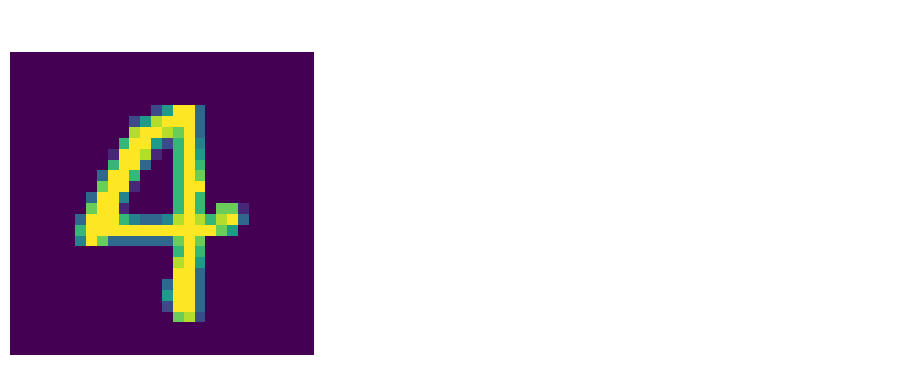

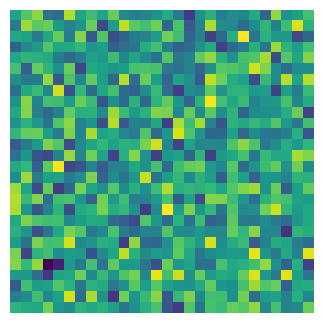

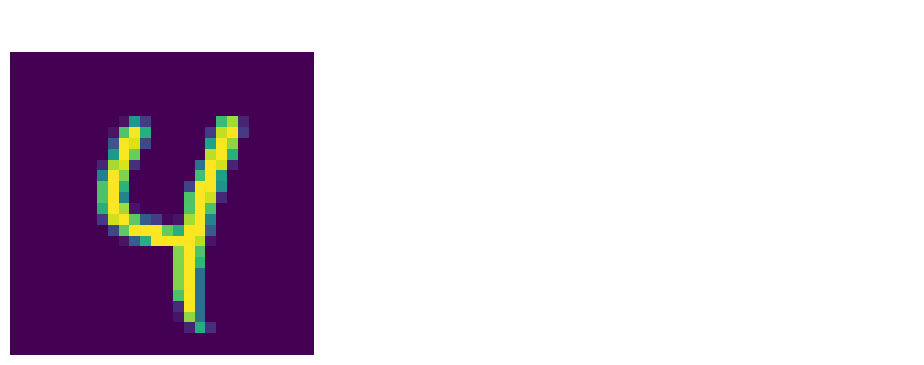

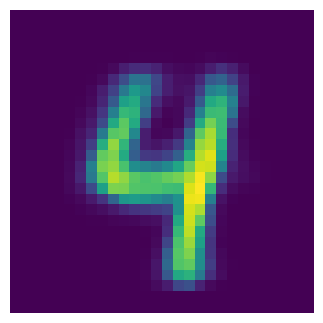

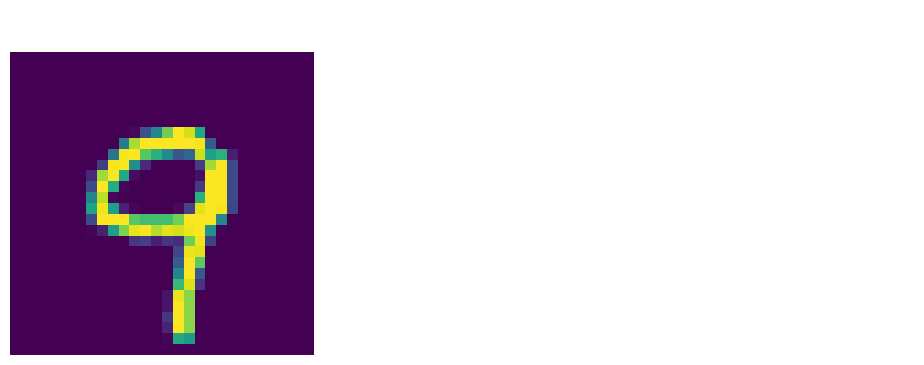

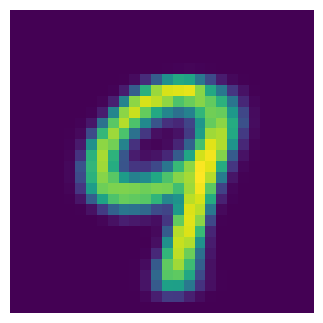

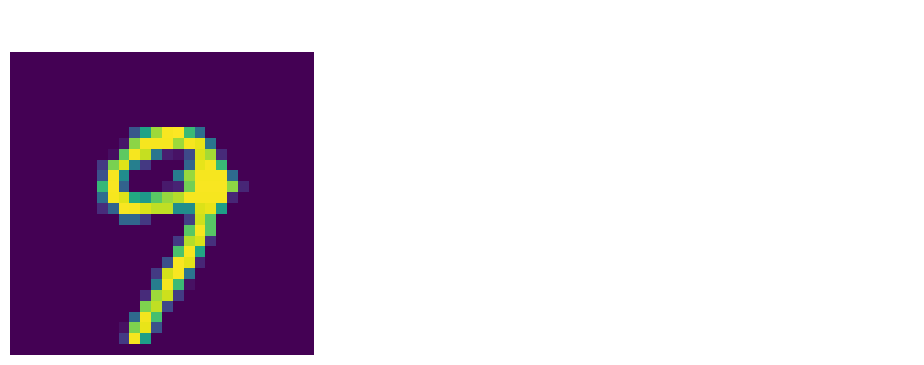

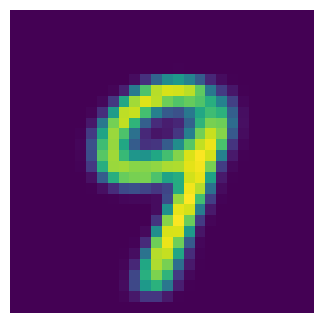

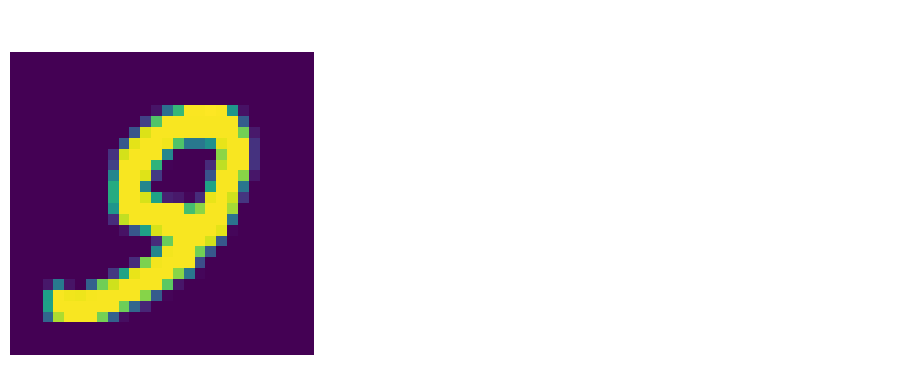

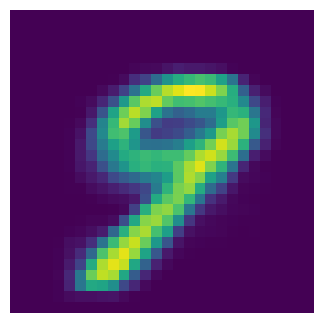

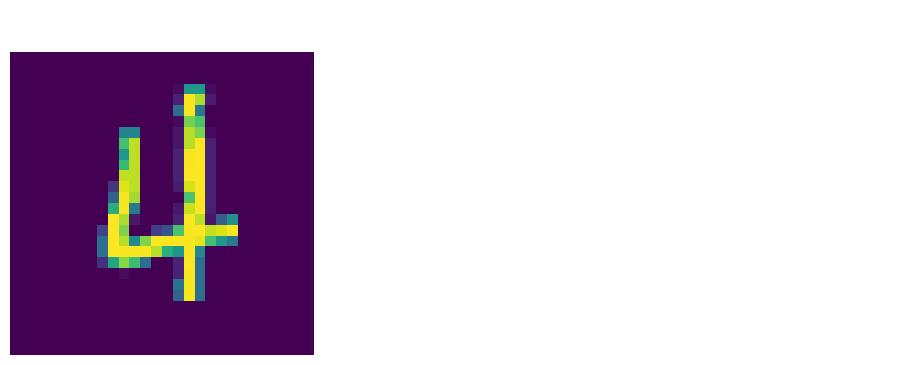

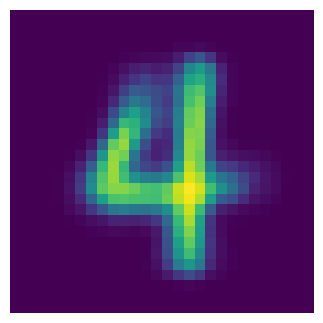

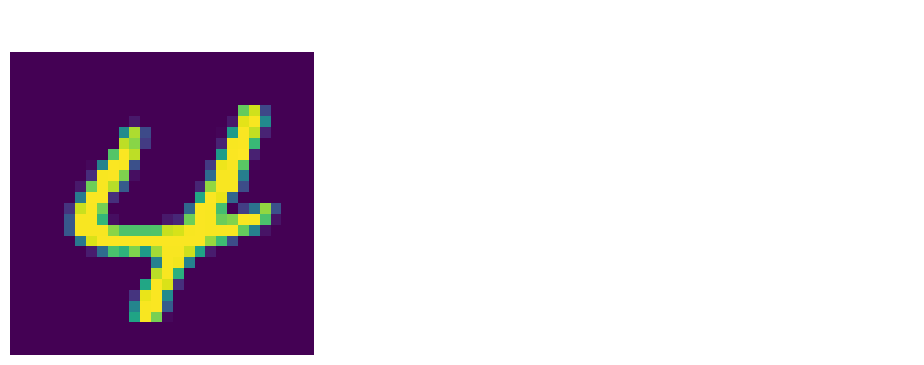

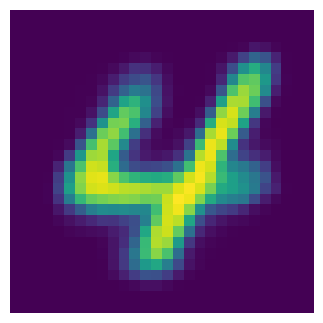

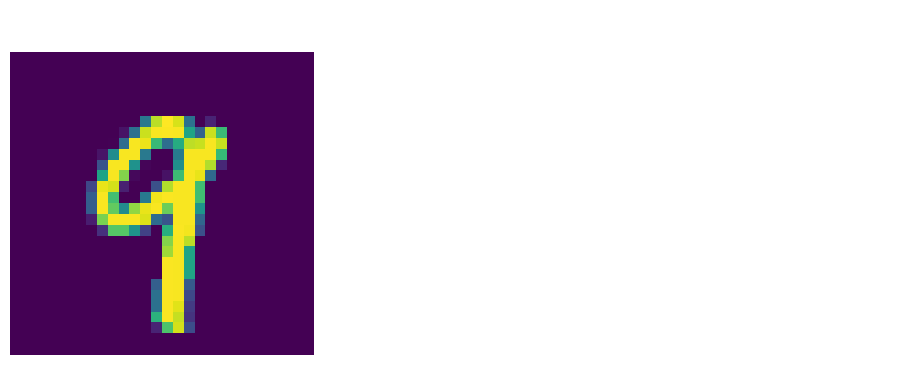

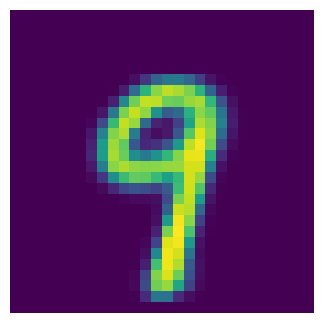

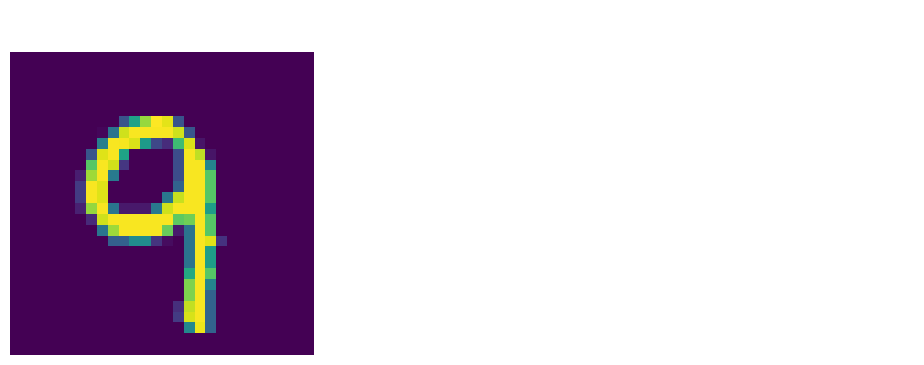

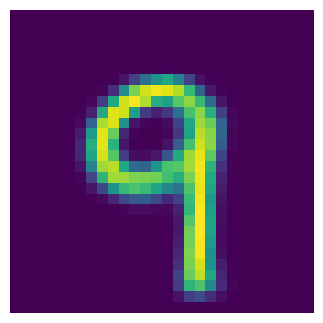

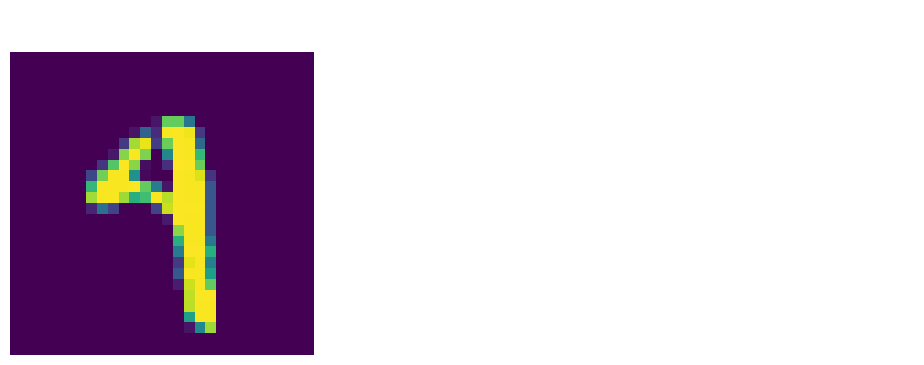

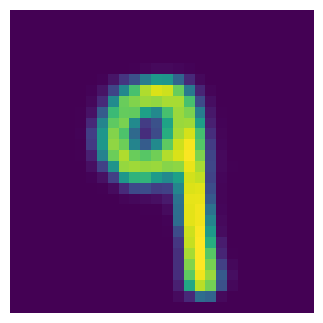

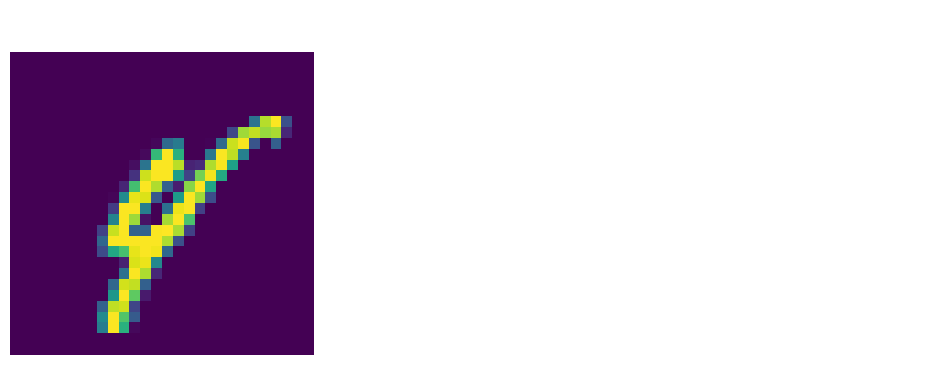

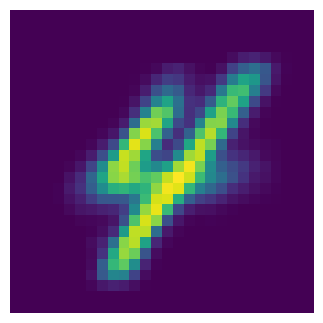

In [668]:
# Training and testing the VAE

epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar, y)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar,y).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

In [616]:
from typing import TypedDict

VAEResult = TypedDict('VAEResult', {'mu': torch.Tensor, 'logvar': torch.Tensor, 'label': torch.Tensor})

def run_VAE(vae: torch.nn.Module, loader: torch.utils.data.DataLoader) -> VAEResult: 
    codes = dict(mu=list(), logvar=list(), label=list())
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        vae.eval()
        for x, y in loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = vae(x)
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['mu'] = torch.cat(means)
    codes['logvar']= torch.cat(logvars)
    codes['label'] = torch.cat(labels)
    return codes


In [682]:
null_codes = run_VAE(model, train_null_only)

In [683]:
null_codes['mu'] #null_codes['mu'].mean(0)

tensor([[-0.3553,  1.3045,  0.0487,  2.3896,  2.2724],
        [ 1.9964,  1.8722,  0.7035,  1.5108,  1.8781],
        [ 0.1357,  1.1749,  1.4425,  1.2308,  1.3986],
        ...,
        [ 0.4764,  0.8687, -0.2299,  0.5864,  2.3917],
        [-0.3881,  0.3333,  1.2132, -1.5214, -1.0620],
        [-0.2356, -0.0406,  1.6152,  0.2513,  1.8448]])

In [684]:
null_codes['mu'][0]

tensor([-0.3553,  1.3045,  0.0487,  2.3896,  2.2724])

In [635]:
(null_codes['mu'] - null_codes['mu'].mean(0)).T.cov()

tensor([[0.9197, 0.1554],
        [0.1554, 1.2641]])

In [636]:
def get_codes_mean_and_cov(codes):
        mean_tensor = codes['mu'].mean(0)
        centered_means = codes['mu'] - mean_tensor
        vcov = centered_means.T.cov()
        return dict(mean=mean_tensor, vcov=vcov)

In [715]:
null_codes = run_VAE(model, train_null_only)
positive_codes = run_VAE(model, train_positive_only)

null_stats = get_codes_mean_and_cov(null_codes)
positive_stats = get_codes_mean_and_cov(positive_codes)

In [716]:
null_codes

{'mu': tensor([[ 1.7690, -0.4464,  0.1710,  1.6032, -0.3434],
         [-0.0368,  0.1574,  2.7064, -1.0143,  0.8844],
         [ 1.0909,  1.6138,  0.5117,  0.3752,  0.0445],
         ...,
         [-0.5266,  0.4029,  0.5885,  1.8705,  1.1707],
         [ 2.0530,  0.4813, -0.7297, -1.0947,  1.1807],
         [ 1.9044, -1.9548, -0.4156,  1.3792,  1.6965]]),
 'logvar': tensor([[-2.8764, -2.5533, -1.9007, -2.7745, -2.0519],
         [-3.0848, -2.1833, -1.8601, -3.0174, -2.1587],
         [-3.4872, -2.3618, -1.8926, -2.8428, -2.4269],
         ...,
         [-2.6462, -1.9605, -1.6450, -2.8938, -2.4229],
         [-3.0374, -2.3368, -1.5099, -2.4015, -2.1357],
         [-3.2927, -2.7664, -1.5922, -3.4098, -2.2400]]),
 'label': tensor([4, 4, 4,  ..., 4, 4, 4])}

In [717]:
null_stats

{'mean': tensor([0.7254, 0.9089, 0.8506, 0.8672, 0.9260]),
 'vcov': tensor([[ 0.9888, -0.0598, -0.0753, -0.0189, -0.1095],
         [-0.0598,  0.9031, -0.0820,  0.1013, -0.0331],
         [-0.0753, -0.0820,  0.8764, -0.1147, -0.0286],
         [-0.0189,  0.1013, -0.1147,  1.2675, -0.0334],
         [-0.1095, -0.0331, -0.0286, -0.0334,  0.9850]])}

In [718]:
positive_stats

{'mean': tensor([-0.8741, -0.9377, -0.8721, -0.9047, -0.8191]),
 'vcov': tensor([[ 1.3301, -0.0447,  0.0293, -0.1604, -0.1878],
         [-0.0447,  0.9001,  0.1427, -0.1333,  0.0879],
         [ 0.0293,  0.1427,  0.6249,  0.0190, -0.1139],
         [-0.1604, -0.1333,  0.0190,  1.0146, -0.0260],
         [-0.1878,  0.0879, -0.1139, -0.0260,  0.9177]])}

In [719]:
all_centered_means = torch.cat((null_codes['mu'], positive_codes['mu']))
common_vcov= all_centered_means.T.cov()

In [740]:
common_vcov

tensor([[1.8006, 0.6863, 0.6663, 0.6183, 0.5488],
        [0.6863, 1.7540, 0.8267, 0.8009, 0.8336],
        [0.6663, 0.8267, 1.4913, 0.7158, 0.6799],
        [0.6183, 0.8009, 0.7158, 1.9247, 0.7433],
        [0.5488, 0.8336, 0.6799, 0.7433, 1.7122]])

In [737]:
null_stats['mean'].requires_grad

False

In [722]:
mv_null = MultivariateNormal(null_stats['mean'], common_vcov)
mv_positive = MultivariateNormal(positive_stats['mean'], common_vcov)

In [739]:
x3[1].requires_grad

True

In [723]:
mv_positive.log_prob(x3[1]) - mv_null.log_prob(x3[1])

tensor([0.9356], grad_fn=<SubBackward0>)

In [724]:
mv_positive.log_prob(x4[1]) - mv_null.log_prob(x4[1])

tensor([-1.5605], grad_fn=<SubBackward0>)

In [727]:
class LikelihoodRatioModel():
    def __init__(self, null_mv, positive_mv):
        self.null_mv = null_mv
        self.positive_mv = positive_mv
    
    def __call__(self, value):
        return self.positive_mv.log_prob(value) - self.null_mv.log_prob(value)


In [728]:
lr = LikelihoodRatioModel(mv_null, mv_positive)

In [731]:
lr(x4[1])

tensor([-1.5605], grad_fn=<SubBackward0>)

====> Test set loss: 11.6433
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])


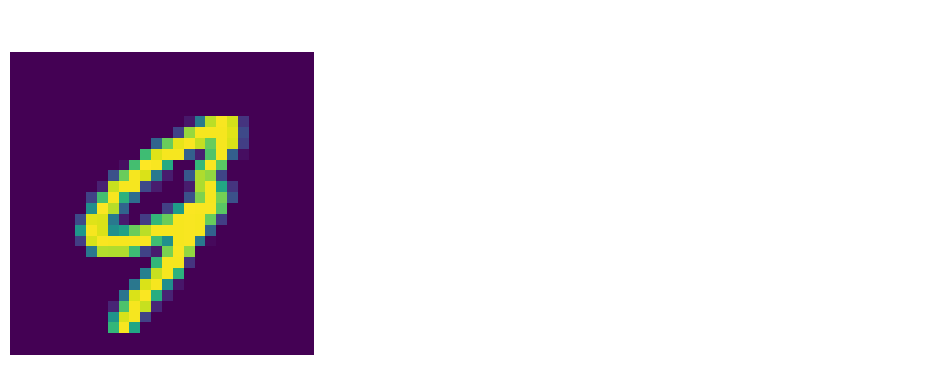

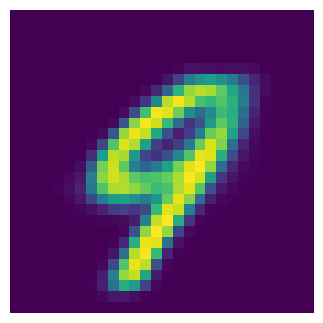

In [707]:
null_codes = dict(μ=list(), logσ2=list(), y=list())
# Testing
means, logvars, labels = list(), list(), list()
with torch.no_grad():
    model.eval()
    test_loss = 0
    for x, y in test_positive_only:
        x = x.to(device)
        # ===================forward=====================
        x_hat, mu, logvar = model(x)
        test_loss += loss_function(x_hat, x, mu, logvar,y).item()
        # =====================log=======================
        means.append(mu.detach())
        logvars.append(logvar.detach())
        labels.append(y.detach())
# ===================log========================
null_codes['μ'].append(torch.cat(means))
null_codes['logσ2'].append(torch.cat(logvars))
null_codes['y'].append(torch.cat(labels))
test_loss /= len(test_loader.dataset)
print(f'====> Test set loss: {test_loss:.4f}')
display_images(x, x_hat, 1, f'Epoch {epoch}')

In [712]:
x3= model(x2[0])

In [713]:
x3[1]

tensor([[-1.9062, -0.2057,  0.1774,  0.4238, -1.0976]],
       grad_fn=<SliceBackward0>)

In [703]:
x4 = model(x3[0])

In [704]:
x4[1]

tensor([[-0.5494,  0.0462,  1.7126,  1.5685,  0.9924]],
       grad_fn=<SliceBackward0>)

torch.Size([1, 784])
torch.Size([1, 28, 28])


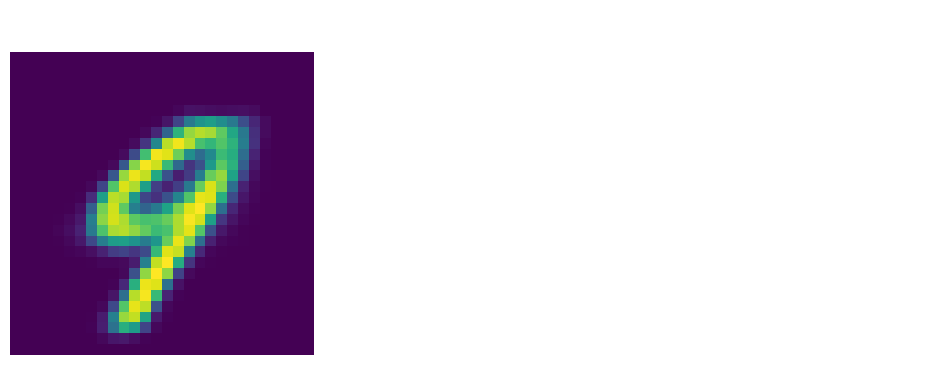

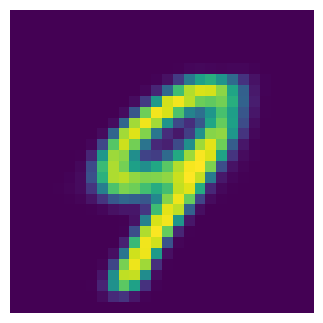

In [714]:
display_images(x2[0], x3[0], 1, f'Epoch {epoch}')

torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])


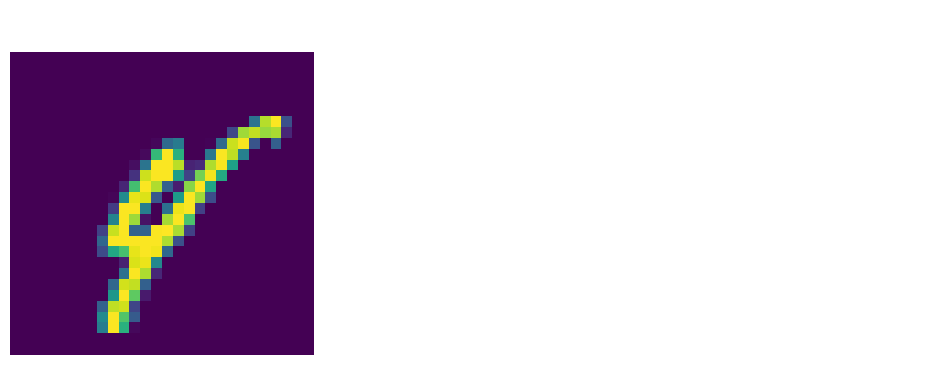

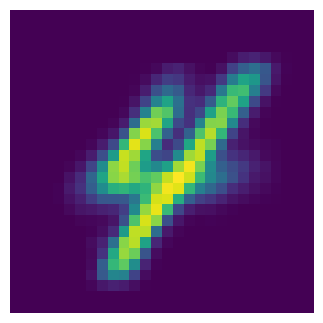

In [685]:
display_images(x, x_hat, 1, f'Epoch {epoch}')

In [601]:
torch.cov(null_codes['μ'][0].T)

tensor([[0.8565, 0.1139],
        [0.1139, 1.1468]])

In [4]:
test_mu_null_tensor = torch.Tensor(null_codes['μ'][0])
std_fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
std_fig.suptitle('Marginal Distributions of Z')
for i in range(2):
    ax = axes[i]
    # ax = axes[int(i/3),i%3]
    ax.hist(test_mu_null_tensor[:,i].numpy(), 20)
    ax.set_title(F"Element {i}")
plt.show()

NameError: name 'torch' is not defined

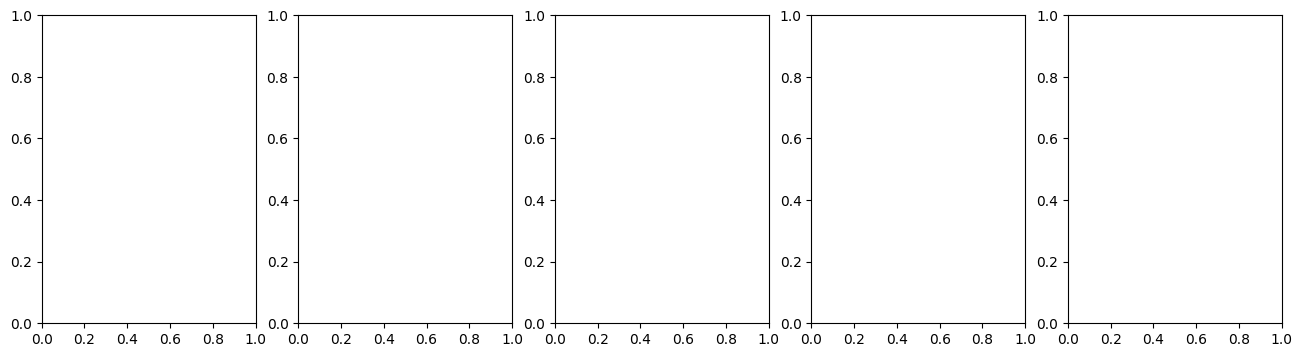

In [8]:
from matplotlib import pyplot as plt
std_fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,4))

In [534]:
print("mean")
print(test_mu_null_tensor[:,0].mean(),test_mu_null_tensor[:,1].mean()) 
print(test_mu_null_tensor[:,0].median(),test_mu_null_tensor[:,1].median()) 

mean
tensor(0.7881) tensor(0.7970)
tensor(0.7613) tensor(0.8243)


====> Test set loss: 1.0000
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])


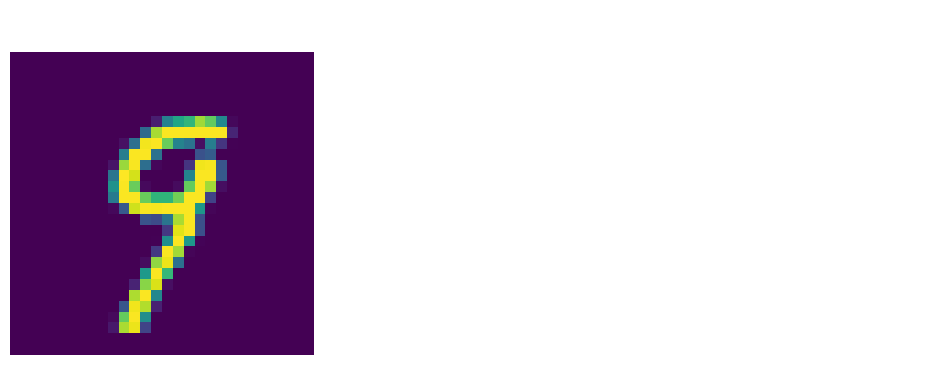

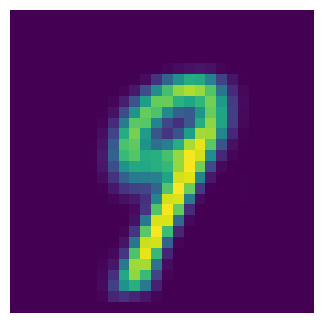

In [535]:
test_codes = dict(μ=list(), logσ2=list(), y=list())
# Testing
means, logvars, labels = list(), list(), list()
with torch.no_grad():
    model.eval()
    test_loss = 0
    for x, y in test_positive_only:
        # for i in range(500):
        x = x.to(device)
        # ===================forward=====================
        x_hat, mu, logvar = model(x)
        # test_loss += loss_function(x_hat, x, mu, logvar).item()
        # =====================log=======================
        means.append(mu.detach())
        logvars.append(logvar.detach())
        labels.append(y.detach())
# ===================log========================
test_codes['μ'].append(torch.cat(means))
test_codes['logσ2'].append(torch.cat(logvars))
test_codes['y'].append(torch.cat(labels))
test_loss = 1
# test_loss /= len(test_loader.dataset)
print(f'====> Test set loss: {test_loss:.4f}')
display_images(x, x_hat, 1, f'Epoch {epoch}')

In [239]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

In [448]:
mv0 = MultivariateNormal(torch.zeros(2), torch.eye(2))
n0 = Normal(0,1)

In [449]:
mv0.log_prob(torch.tensor([0,0])).exp_()

tensor(0.1592)

In [452]:
n0.log_prob(torch.tensor(0)).exp_() / 2

tensor(0.1995)

In [441]:
print(mv0.log_prob(null_codes['μ'][0][5]))

tensor(-2.3426)


In [536]:
test_codes['μ'][0].shape

torch.Size([1009, 2])

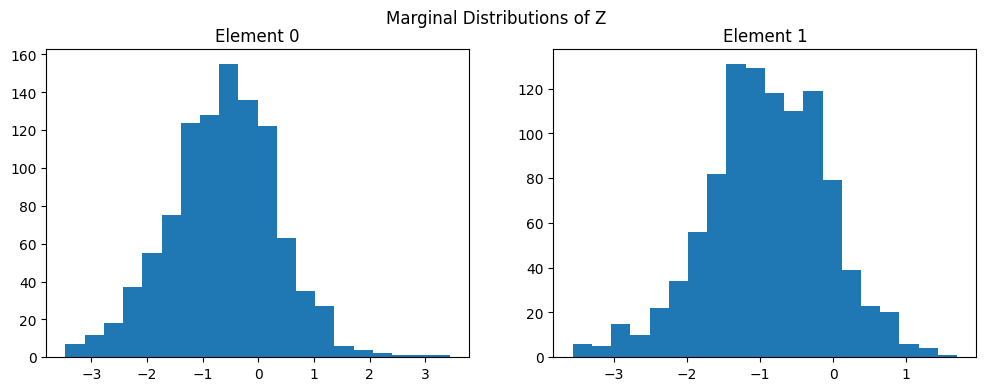

In [537]:
test_mu_positive_tensor = torch.Tensor(test_codes['μ'][0])
std_fig, axes = plt.subplots(nrows=1, ncols=d, figsize=(12,4))
std_fig.suptitle('Marginal Distributions of Z')
for i in range(d):
    ax = axes[i]
    # ax = axes[int(i/3),i%3]
    ax.hist(test_mu_positive_tensor[:,i].numpy(), 20)
    ax.set_title(F"Element {i}")
plt.show()
# plt.hist(test_mu_positive_tensor[:,0])

In [529]:
print("mean")
print(test_mu_positive_tensor[:,0].mean(),test_mu_positive_tensor[:,1].mean()) 
print("median")
print(test_mu_positive_tensor[:,0].median(),test_mu_positive_tensor[:,1].median()) 

mean
tensor(-0.7163) tensor(-0.9149)
median
tensor(-0.6908) tensor(-0.9039)


In [149]:
import pandas as pd
df = pd.DataFrame(test_mu_tensor.numpy())
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4
0,1.000000,0.290156,-0.496818,-0.186036,-0.215787
1,0.290156,1.000000,-0.173030,0.070816,-0.172126
2,-0.496818,-0.173030,1.000000,-0.059305,0.047125
3,-0.186036,0.070816,-0.059305,1.000000,0.034056
4,-0.215787,-0.172126,0.047125,0.034056,1.000000


In [646]:
mv = MultivariateNormal(positive_stats['mean'], positive_stats['vcov'])
for i in range(100):
    print(mv.sample())

tensor([-0.5902, -1.2419])
tensor([-1.5897, -2.1867])
tensor([-0.0735, -1.3861])
tensor([ 1.4381, -1.5788])
tensor([-0.4641, -0.5835])
tensor([-0.2084, -0.5368])
tensor([-0.9810, -0.3642])
tensor([-0.3146, -1.1131])
tensor([-0.3866, -2.2506])
tensor([-2.0480, -1.1601])
tensor([-0.1613, -0.7816])
tensor([-0.2272, -0.8317])
tensor([ 0.3797, -2.5478])
tensor([-0.6114, -0.8682])
tensor([-0.9720, -1.9348])
tensor([-2.3248,  0.5261])
tensor([-1.3940, -1.5334])
tensor([-1.4185, -1.0013])
tensor([ 1.1781, -1.0914])
tensor([ 0.4417, -0.3020])
tensor([0.1998, 0.1126])
tensor([-0.3445, -1.3856])
tensor([ 0.1355, -1.2403])
tensor([-0.4496, -0.3171])
tensor([-0.3473, -1.0848])
tensor([-0.3533, -2.1827])
tensor([ 1.1643, -1.1375])
tensor([-0.6850, -2.1473])
tensor([ 0.6914, -0.7991])
tensor([-1.1797, -1.9208])
tensor([-2.4635e-04, -3.9351e-01])
tensor([-2.5137, -0.0177])
tensor([ 2.2859, -1.0668])
tensor([ 0.0352, -1.2895])
tensor([-0.5361, -0.6812])
tensor([-1.9465, -1.0461])
tensor([-0.0945, -0.00

In [681]:
mv.sample(torch.Size([2
                     ]))

tensor([[-2.2312, -1.7520],
        [-1.4001, -0.9307]])

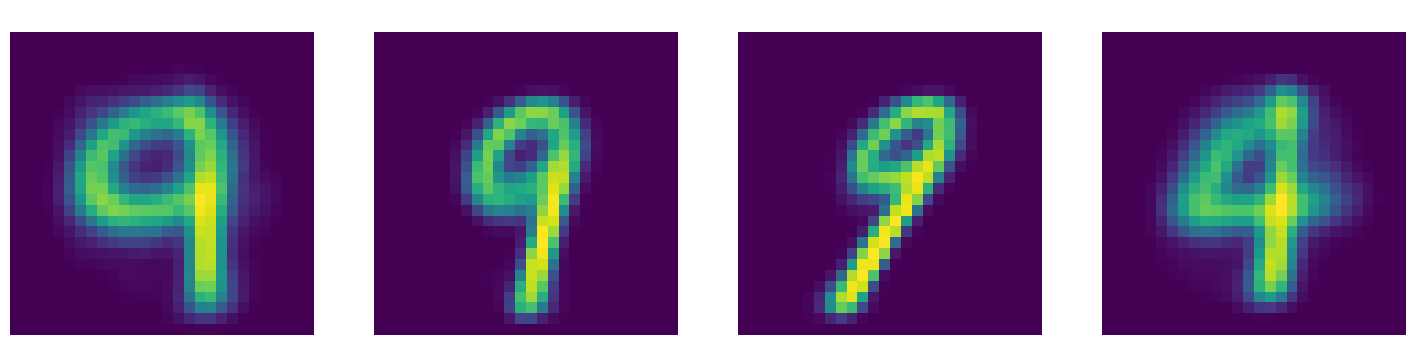

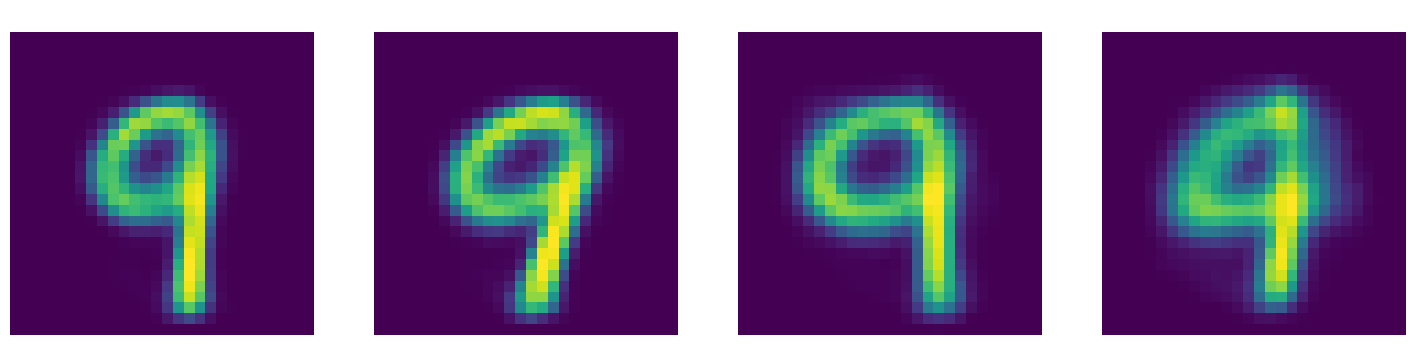

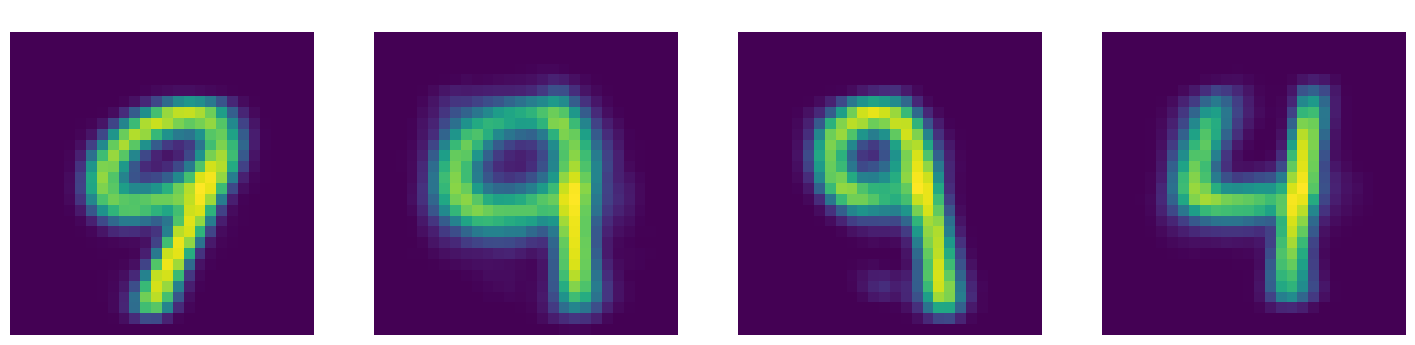

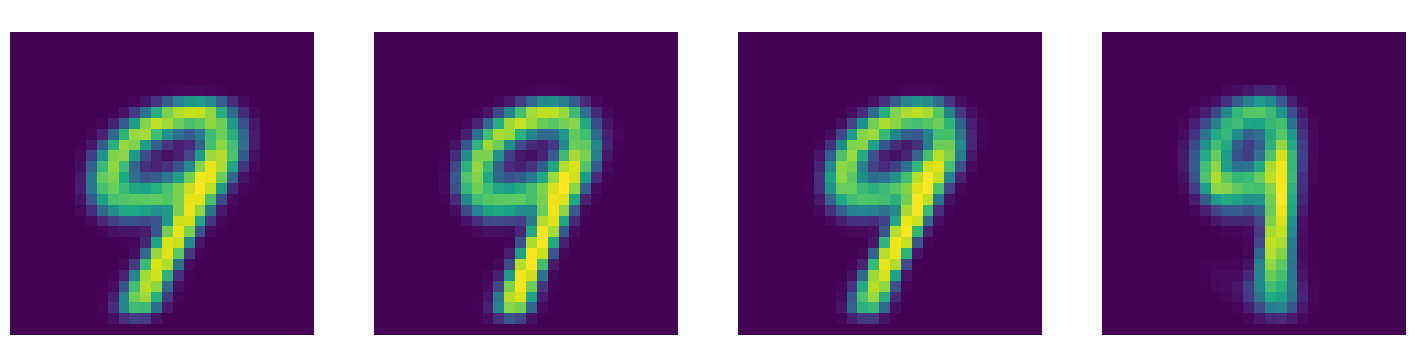

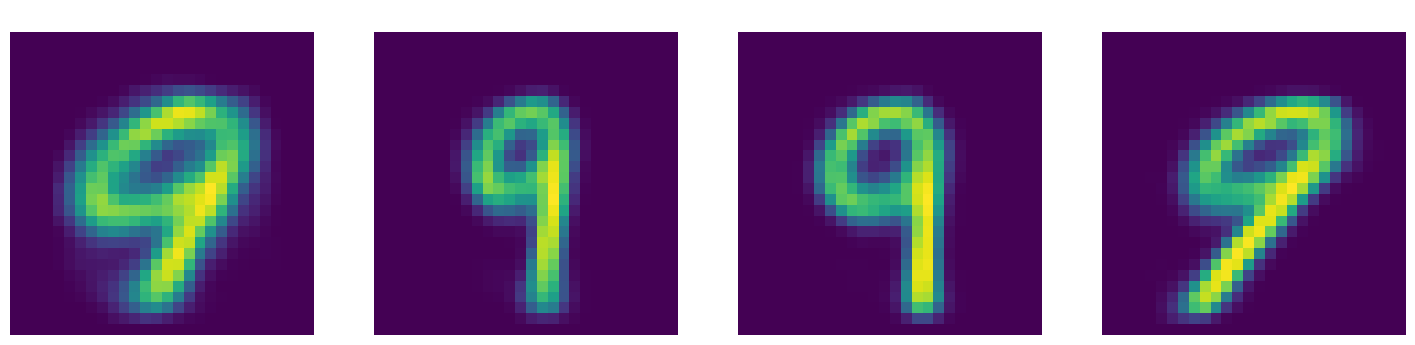

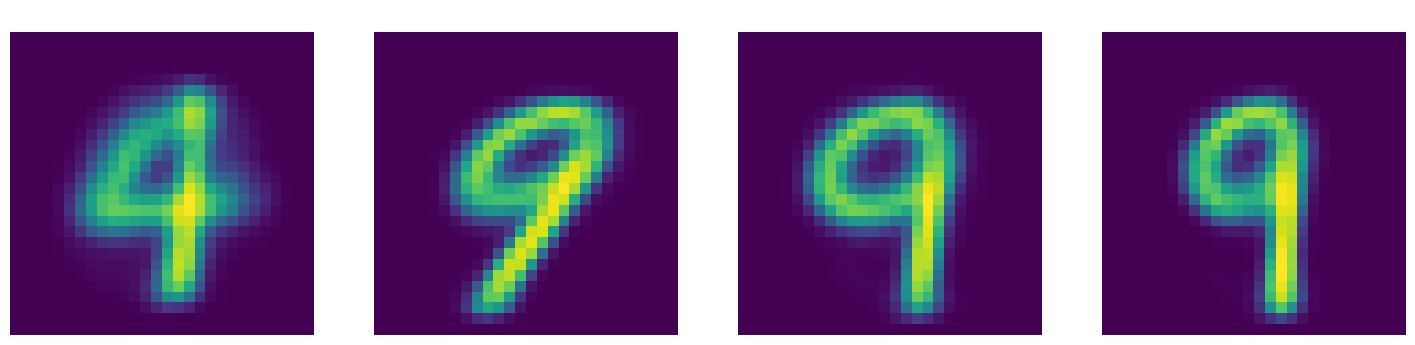

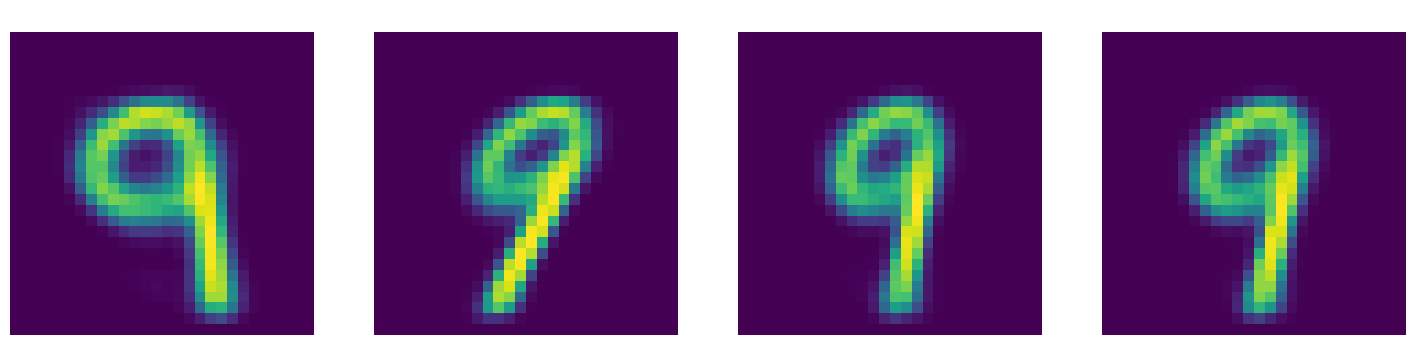

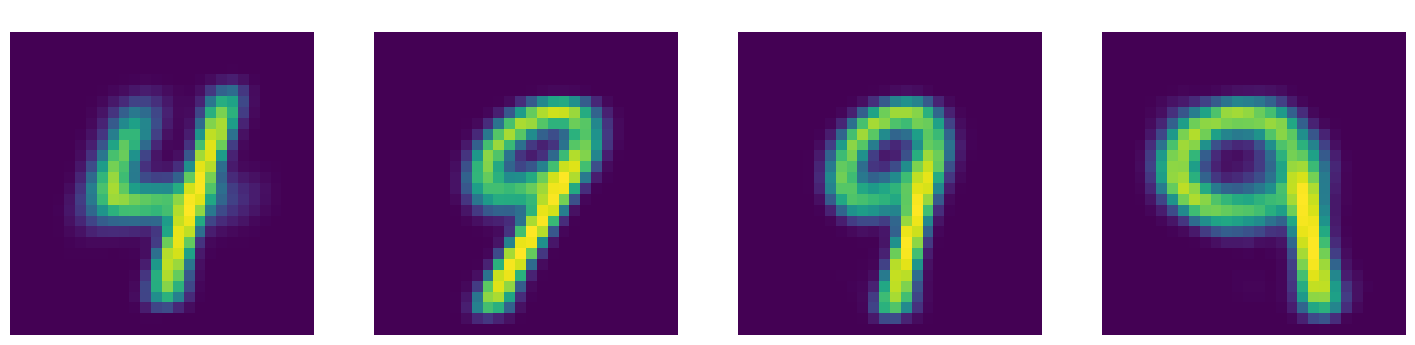

In [649]:
# Generating a few samples

N = 32
# z = torch.randn((N, d)).to(device)
# z = torch.normal(torch.tensor([1.0,1.0]).repeat(N,1), torch.ones(N,2)).to(device)
mv = MultivariateNormal(positive_stats['mean'], positive_stats['vcov'])
z = mv.sample(torch.Size([N]))
# sample = model.decoder(torch.from_numpy(x0).type(torch.FloatTensor))
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

IndexError: index 8 is out of bounds for dimension 0 with size 8

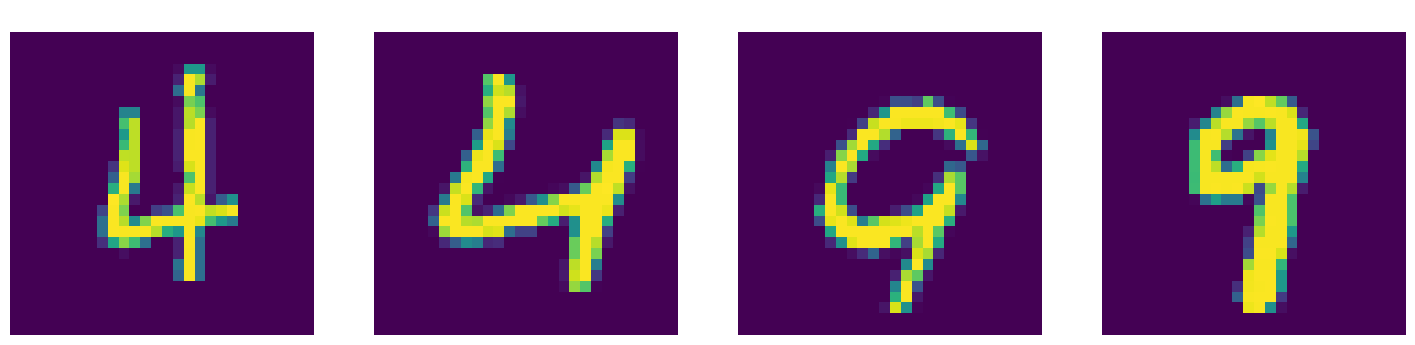

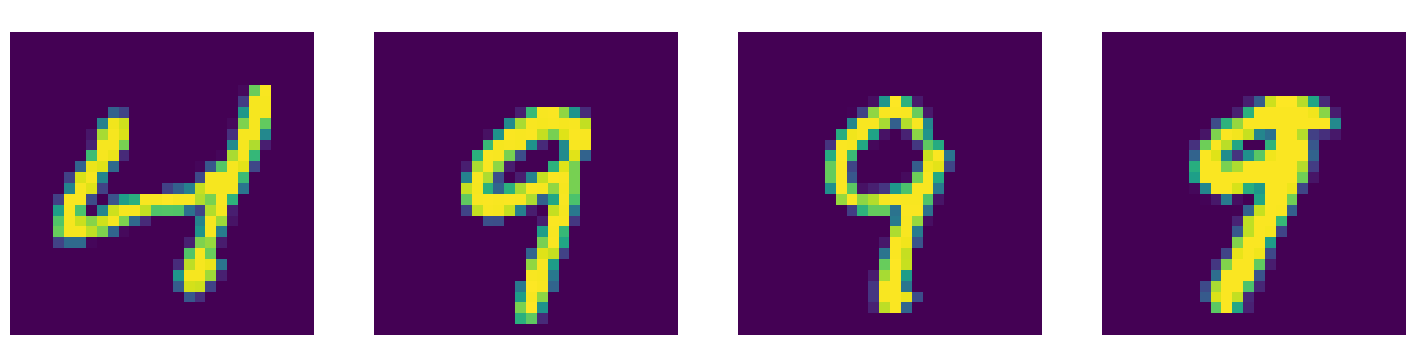

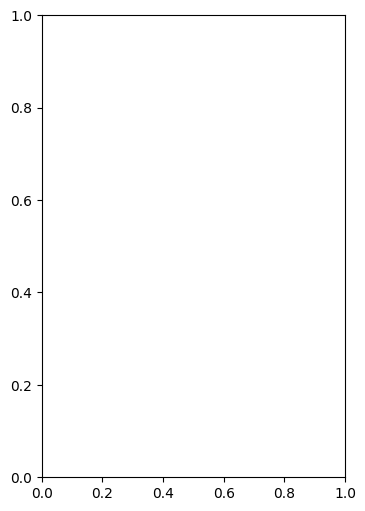

In [91]:
# Display last test batch

display_images(None, x, 4, count=True)

In [547]:
mu.shape

torch.Size([1, 2])

In [542]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

IndexError: index 1 is out of bounds for dimension 0 with size 1

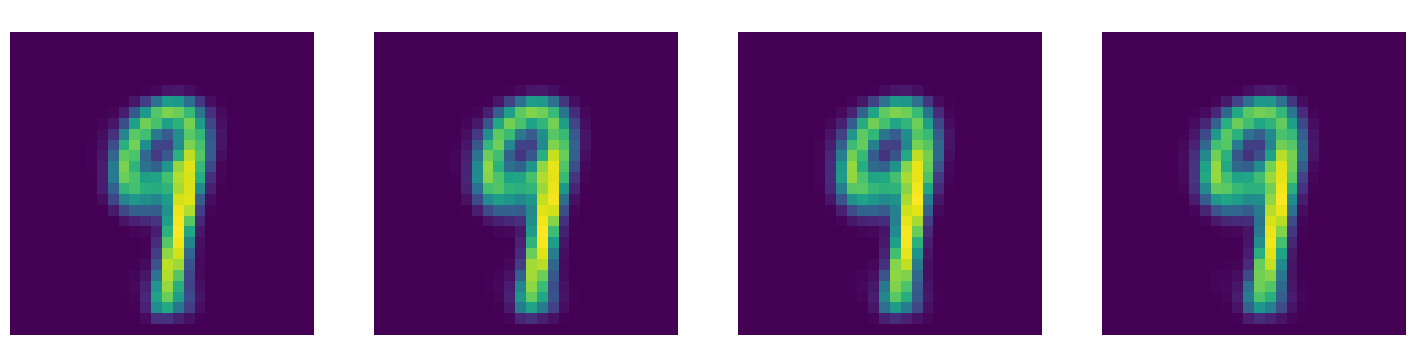

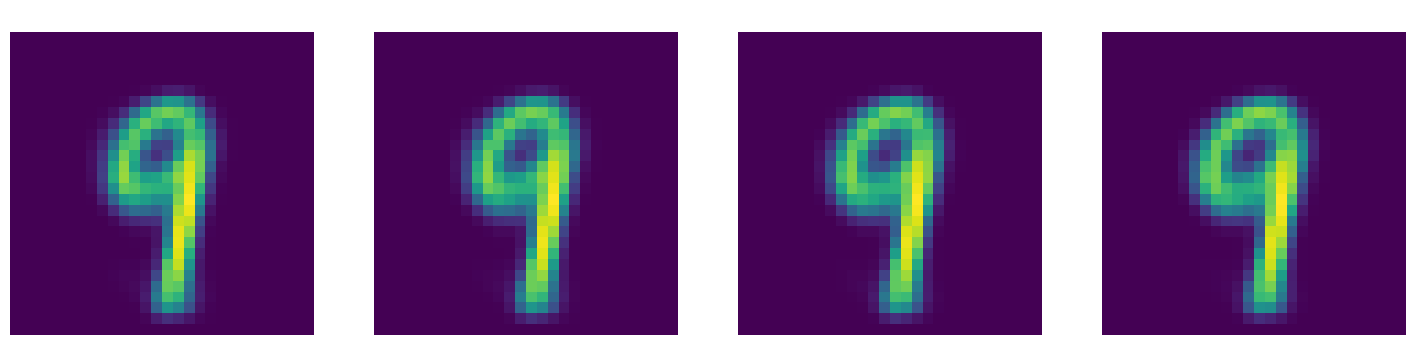

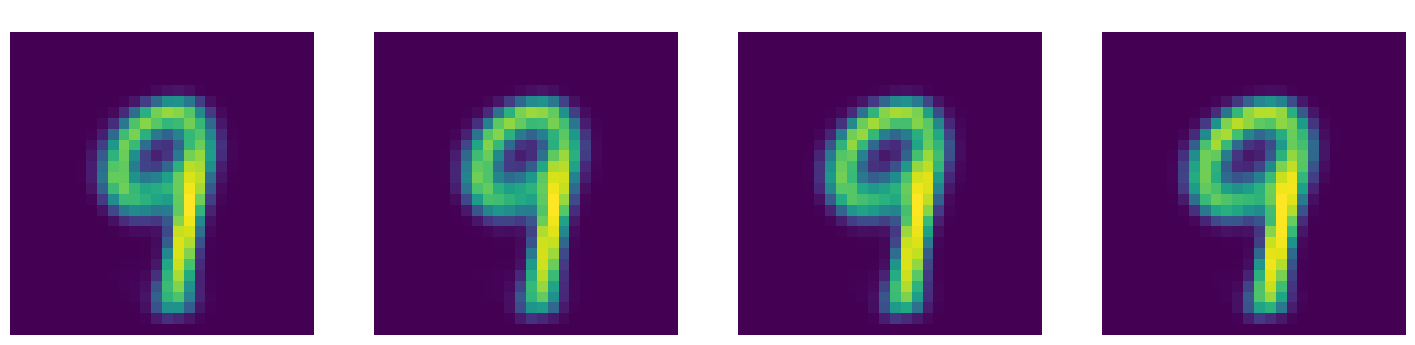

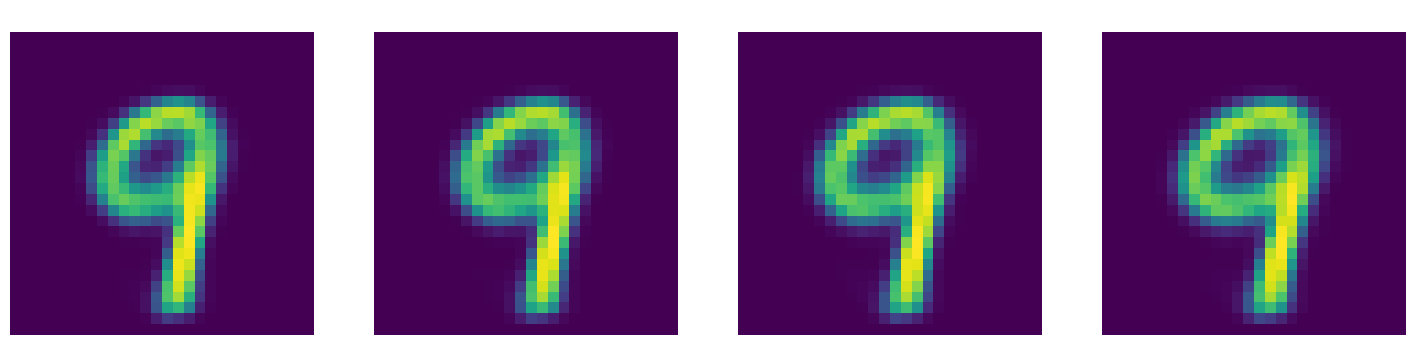

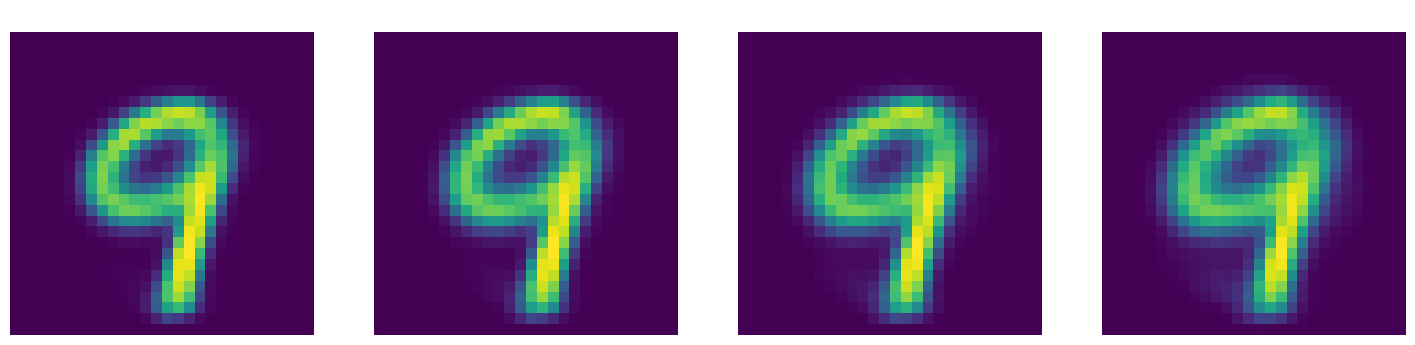

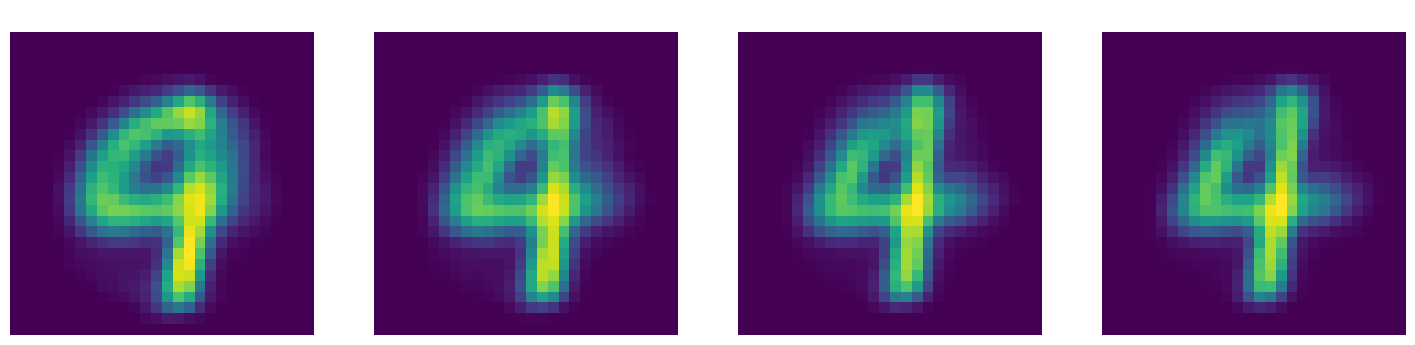

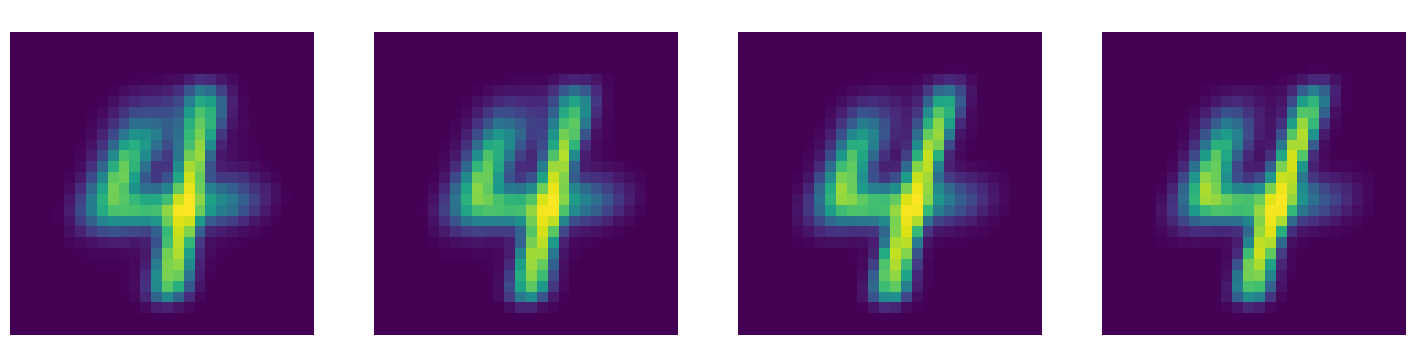

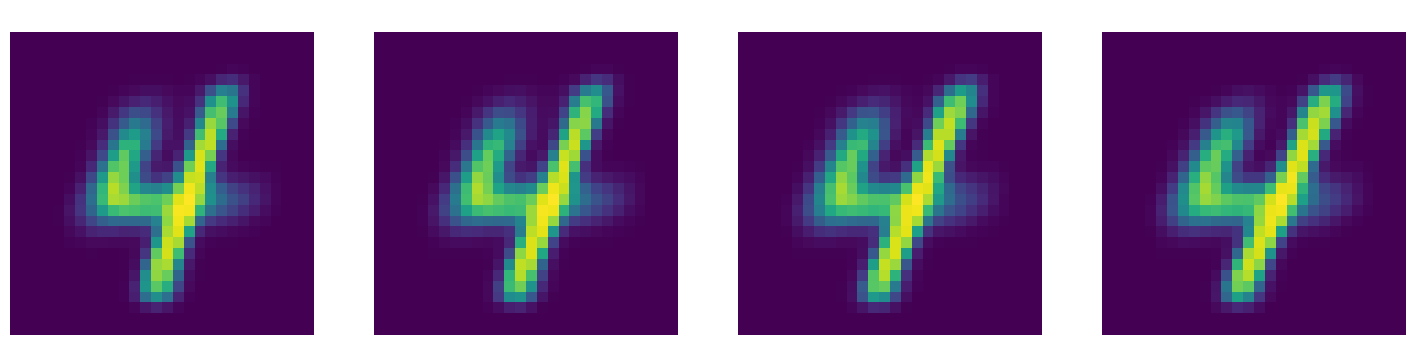

In [556]:
# Perform an interpolation between input A and B, in N steps

N = 32
mu4 = torch.normal(torch.tensor([1.0,1.0]), torch.ones(1,2)).to(device)
mu9 = torch.normal(torch.tensor([-1.0,-1.0]), torch.ones(1,2)).to(device)
code = torch.Tensor(N, 2).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu4.data + (1 - i / (N - 1) ) * mu9.data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [53]:
import numpy as np
from sklearn.manifold import TSNE
from res.plot_lib import set_default

ModuleNotFoundError: No module named 'res'

In [ ]:
set_default(figsize=(15, 4))

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

In [ ]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)